In [2]:
# !pip install --target="/content/drive/MyDrive/Colab Notebooks/Yolo8" ultralytics

In [7]:
# Checking that GPU is available
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [8]:
# Installing Ultralytics's YOLO model
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [9]:
# Checking that YOLO was installed correctly
!yolo check

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.6/107.7 GB disk)

OS                  Linux-6.1.85+-x86_64-with-glibc2.35
Environment         Colab
Python              3.10.12
Install             pip
RAM                 12.67 GB
CPU                 Intel Xeon 2.20GHz
CUDA                None

numpy               ✅ 1.26.4<2.0.0,>=1.23.0
matplotlib          ✅ 3.7.1>=3.3.0
opencv-python       ✅ 4.10.0.84>=4.6.0
pillow              ✅ 9.4.0>=7.1.2
pyyaml              ✅ 6.0.1>=5.3.1
requests            ✅ 2.32.3>=2.23.0
scipy               ✅ 1.13.1>=1.4.1
torch               ✅ 2.3.1+cu121>=1.8.0
torchvision         ✅ 0.18.1+cu121>=0.9.0
tqdm                ✅ 4.66.5>=4.64.0
psutil              ✅ 5.9.5
py-cpuinfo          ✅ 9.0.0
pandas              ✅ 2.1.4>=1.1.4
seaborn             ✅ 0.13.1>=0.11.0
ultralytics-thop    ✅ 2.0.0>=2.0.0


In [13]:
# Importing required packages
import os
import cv2
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from ultralytics import YOLO

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

In [11]:
# Accessing Google Drive from Google Colab to access dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Dataset

I will work with [Vehicle Detection in Aerial Imagery (VEDAI) dataset](https://universe.roboflow.com/ntokozo-nhlangothi-w6os9/vedai-roboflow/dataset/1) (v1) found at Roboflow Universe resource. Dataset was initially created by Sebastien Razakarivony and Frederic Jurie in 2014. Roboflow collection was prepared specifically for YOLOv8 and contains 5288 images in total as a JPEG file of size 640x640 pixels.

Dataset contains following classes: plane, boat, camping car, car, pick-up, tractor, truck, van, and other.

Number of samples: 4817
Image shape:       (640, 640, 3)


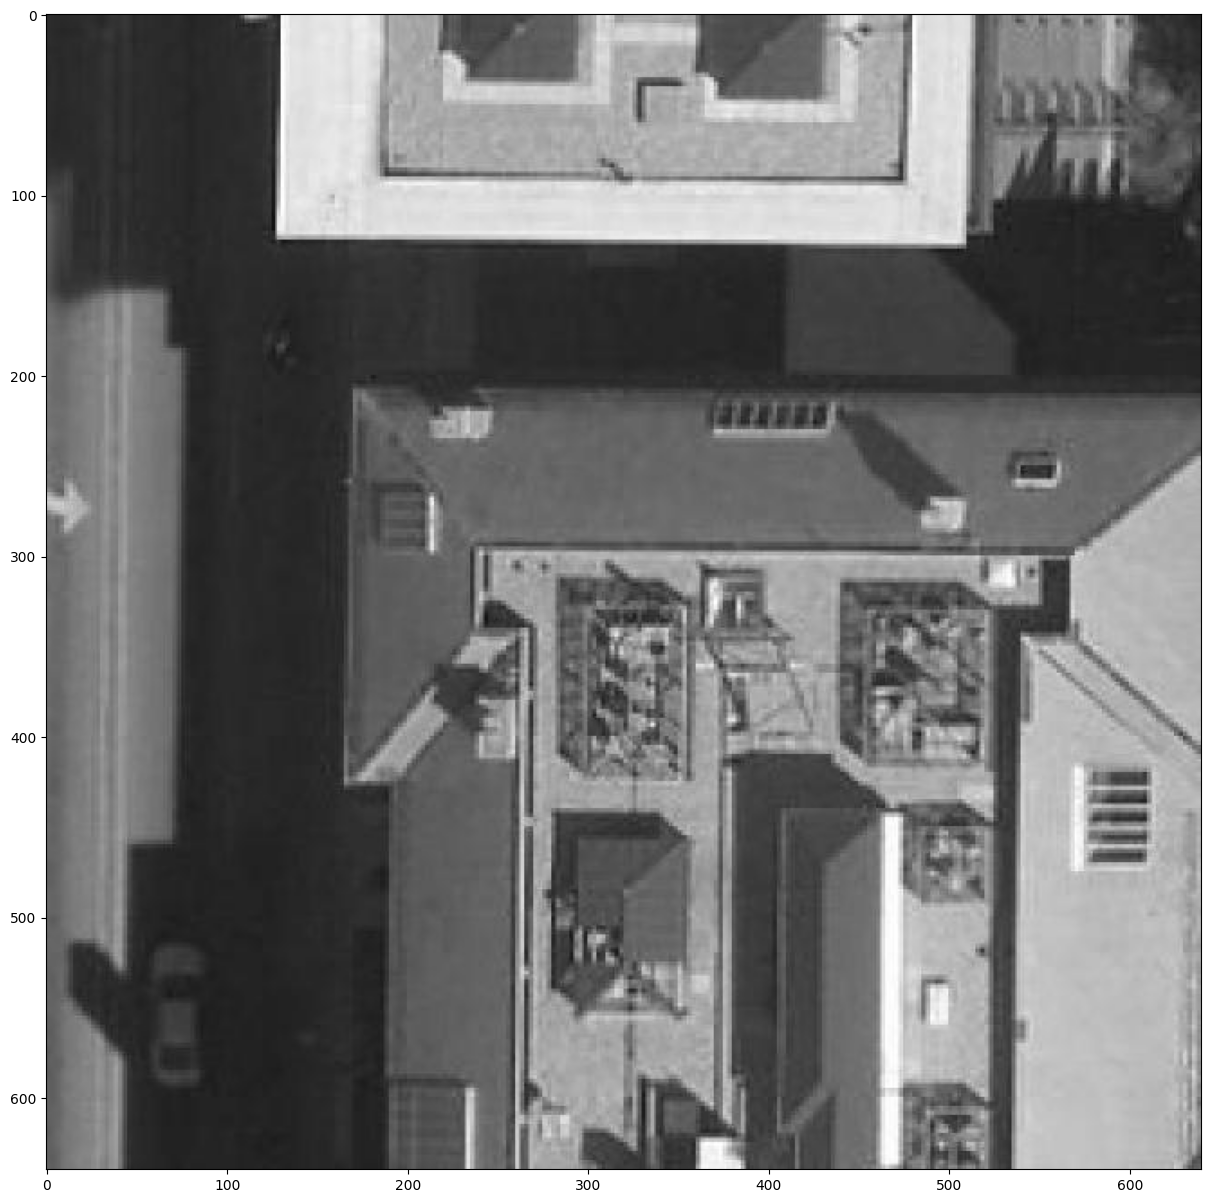

In [12]:
# Let's investigate images in dataset
def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

data_folder = '/content/gdrive/My Drive/Colab Notebooks/VEDAI-Roboflow/train'
imfiles = os.listdir(os.path.join(data_folder, 'images'))
imfiles = [os.path.join(data_folder, 'images', f) for f in imfiles if os.path.splitext(f)[-1] == '.jpg']

sample = random.choice(imfiles)
image = imread(sample)
rows, cols, channels = image.shape

plt.imshow(image)

print('Number of samples:', len(imfiles))
print('Image shape:      ', image.shape)

In [28]:
assert all(cv2.imread(imfile).shape == (rows, cols, channels) for imfile in tqdm(imfiles))

  0%|          | 0/4817 [00:00<?, ?it/s]

In [5]:
# Let's look at what classes and bounding box paramenters we have
annotations_folder = '/content/gdrive/My Drive/Colab Notebooks/VEDAI-Roboflow/train/labels'

annotations = os.listdir(annotations_folder)

data = []

for annotation in annotations:
    if annotation.endswith('.txt'):
        with open(os.path.join(annotations_folder, annotation), 'r') as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])
                box = [float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])]
                data.append({'File': annotation, 'Class': class_id, 'Box': box})

df = pd.DataFrame(data)

df

,File,Class,Box
0,6062_jpg.rf.f5f395e59917ffa5ea7fa0991956f910.txt,2,"[0.1546875, 0.015625, 0.15234375, 0.03125]"
1,6062_jpg.rf.f5f395e59917ffa5ea7fa0991956f910.txt,2,"[0.1484375, 0.0921875, 0.1640625, 0.05859375]"
2,2597_jpg.rf.2bb587a79711ba9c81880870616bfa95.txt,2,"[0.50625, 0.1, 0.16796875, 0.08203125]"
3,12582_jpg.rf.3598f9e1e8c1ae69aa8252e88fd49c05.txt,2,"[0.31875, 0.86328125, 0.07421875, 0.140625]"
4,12582_jpg.rf.3598f9e1e8c1ae69aa8252e88fd49c05.txt,1,"[0.5921875, 0.709375, 0.12109375, 0.27734375]"
...,...,...,...
16066,662_jpg.rf.354826fe3517b487447ab487d56fb310.txt,2,"[0.30625, 0.946875, 0.05859375, 0.08984375]"
16067,662_jpg.rf.354826fe3517b487447ab487d56fb310.txt,2,"[0.9609375, 0.73046875, 0.0703125, 0.125]"
16068,6401_jpg.rf.50422386d099534dd13dd36d8f0271eb.txt,5,"[0.0328125, 0.55546875, 0.065625, 0.1921875]"
16069,6401_jpg.rf.50422386d099534dd13dd36d8f0271eb.txt,1,"[0.1078125, 0.5703125, 0.14453125, 0.1875]"


In [14]:
model = YOLO("yolov8s.pt")
model.info()

100%|██████████| 21.5M/21.5M [00:00<00:00, 133MB/s]


YOLOv8s summary: 225 layers, 11,166,560 parameters, 0 gradients, 28.8 GFLOPs


(225, 11166560, 0, 28.816844800000002)

In [17]:
root = "/content/gdrive/My Drive/Colab Notebooks/VEDAI-Roboflow/"
!yolo task=detect mode=train model=yolov8s.pt data="{root}/data.yaml" epochs=4 imgsz=512 mosaic=0.0 flipud=0.5 scale=0.0

Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/gdrive/My Drive/Colab Notebooks/VEDAI-Roboflow//data.yaml, epochs=4, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

In [ ]:
retrained = YOLO('/content/gdrive/My Drive/Colab Notebooks/VEDAI-Roboflow/runs/detect/train4/weights/best.pt')

In [ ]:
for idx, sample in enumerate(np.random.choice(imfiles, 4)):
    image = cv2.imread(sample)
    image = image[1800:, 1800:, :]

    result = retrained.predict(image, conf=0.2)[0]
    boxes = result.boxes.cpu().numpy().xyxy.astype(np.int16)

    for box_idx, box in enumerate(boxes):
        start, stop = box[0:2], box[2:]
        cv2.rectangle(image, start, stop, color=(0, 0, 255), thickness=5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.putText(image, result.names[result.boxes.cls[box_idx].item()], (box[0], box[1]),
                            cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 6, cv2.LINE_AA)

    plt.subplot(1,4,idx+1), plt.imshow(image)